<br>

# 11주차 과제 1번

<br><br>

# 5. Lab: CNN with TensorFlow (MNIST)
<br>


- MNIST without flattening
- To classify handwritten digits


<br>
<center>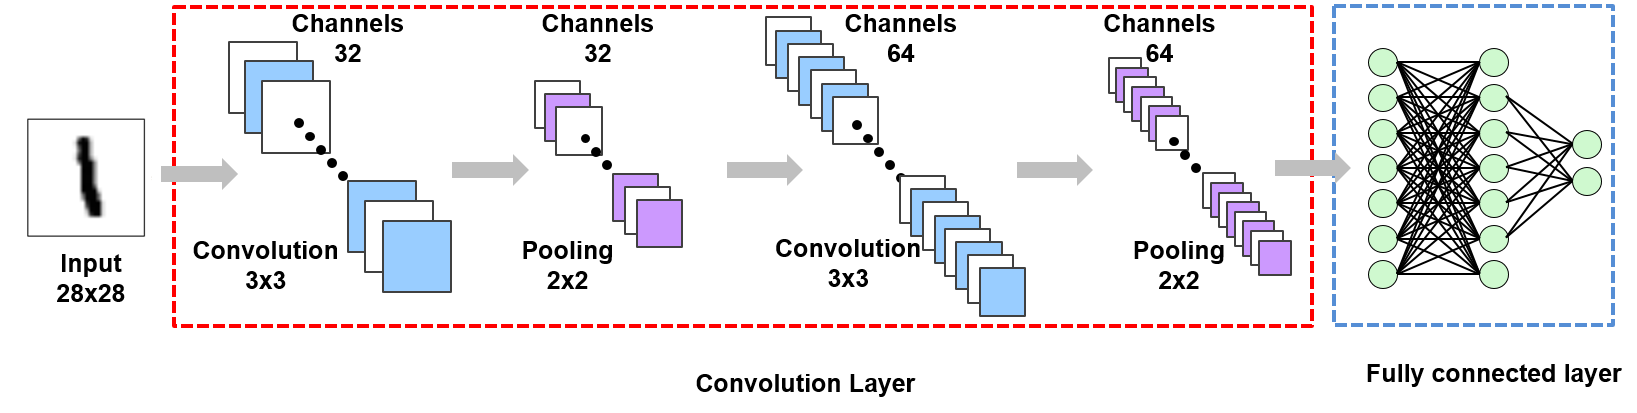</center>
<br>
<br>

In [14]:
## 5.1. Training
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

In [15]:
mnist = tf.keras.datasets.mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()

train_x, test_x = train_x/255.0, test_x/255.0
train_x.shape
train_x = train_x.reshape((train_x.shape[0], 28, 28, 1))
test_x = test_x.reshape((test_x.shape[0], 28, 28, 1))

In [16]:
# input layer
input_h =  28  # input height
input_w =  28  # input width
input_ch = 1   # input channel : Gray scale


# 1st convolution layer
k1_h = 3
k1_w = 3
k1_ch = 32
p1_h = 2
p1_w = 2
# (None, 14, 14, 32)

# 2nd convolution layer
k2_h = 3
k2_w = 3
k2_ch = 64
p2_h = 2
p2_w = 2
# (None, 7, 7, 64)

# Fully connected : flatten the features (7x7x64)
conv_result_size = 7 * 7 * 64
n_hidden = 100
n_output = 10

In [17]:
model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),  # Flatten 대체

    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,426 (111.04 KB)

 Trainable params: 28,426 (111.04 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# [batch, height, width, channels]

def net(x, weights, biases):
    # 1st convolution layer
    conv1 = tf.nn.conv2d(x, weights['w1'], strides=[1, 1, 1, 1], padding='SAME')
    conv1 = tf.nn.relu(conv1 + biases['b1'])
    maxp1 = tf.nn.max_pool(conv1, ksize=[1, p1_h, p1_w, 1], strides=[1, p1_h, p1_w, 1], padding='VALID')
#   maxp1 = tf.nn.max_pool(conv1, ksize=[1,p1_h,p1_w,1], strides=[1,p1_h,p1_w,1], padding='VALID')

    # 2nd convolution layer
    conv2 = tf.nn.conv2d(maxp1, weights['w2'], strides=[1, 1, 1, 1], padding='SAME')
    conv2 = tf.nn.relu(conv2 + biases['b2'])
    maxp2 = tf.nn.max_pool(conv2, ksize=[1, p2_h, p2_w, 1], strides=[1, p2_h, p2_w, 1], padding='VALID')

    maxp2_flatten = tf.reshape(maxp2,[-1, 7 * 7 * 64])

    # Fully connected
    hidden = tf.add(tf.matmul(maxp2_flatten, weights['wd1']), biases['bd1'])
    hidden = tf.nn.relu(hidden)
    output = tf.add(tf.matmul(hidden, weights['out']), biases['out'])

    return output

In [19]:
# Loss function
tf.compat.v1.disable_eager_execution()
x = tf.compat.v1.placeholder(tf.float32, shape=[None, 28, 28, 1])
y = tf.compat.v1.placeholder(tf.float32, shape=[None, 10])

weights = {
    'w1': tf.Variable(tf.random.truncated_normal([3, 3, 1, 32])),  # 1채널 → 32채널
    'w2': tf.Variable(tf.random.truncated_normal([3, 3, 32, 64])), # 32채널→ 64채널
    'wd1': tf.Variable(tf.random.truncated_normal([7*7*64, 100])),
    'out': tf.Variable(tf.random.truncated_normal([100, 10]))
}

biases = {
    'b1': tf.Variable(tf.random.truncated_normal([32])),
    'b2': tf.Variable(tf.random.truncated_normal([64])),
    'bd1': tf.Variable(tf.random.truncated_normal([100])),
    'out': tf.Variable(tf.random.truncated_normal([10]))
}

LR = 0.001
pred = net(x, weights, biases)
loss = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)
loss = tf.reduce_mean(loss)

optm = tf.compat.v1.train.AdamOptimizer(learning_rate=LR).minimize(loss)

# Optimization

n_batch = 50
n_iter = 2500
n_prt = 250

sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())

loss_record_train = []
loss_record_test = []

In [20]:
for epoch in range(n_iter):
    # Get a random batch of training data
    batch_indices = np.random.choice(train_x.shape[0], size=n_batch, replace=False)
    batch_x = train_x[batch_indices]
    batch_y = train_y[batch_indices]

    batch_x = np.reshape(batch_x, (-1, 28, 28, 1))
    # Convert labels to one-hot encoding if necessary
    batch_y = tf.keras.utils.to_categorical(batch_y, num_classes=10)  # Adjust num_classes if needed

    sess.run(optm, feed_dict={x : batch_x, y : batch_y})

    if epoch % n_prt == 0:
        # Get a random batch of test data
        test_batch_indices = np.random.choice(test_x.shape[0], size=n_batch, replace=False)
        test_batch_x = test_x[test_batch_indices]
        test_batch_y = test_y[test_batch_indices]

        test_batch_x = test_batch_x.reshape((n_batch, input_h, input_w, input_ch))
        # Convert labels to one-hot encoding if necessary
        test_batch_y = tf.keras.utils.to_categorical(test_batch_y, num_classes=10)  # Adjust num_classes if needed
        c1 = sess.run(loss, feed_dict={x: batch_x, y: batch_y})
        c2 = sess.run(loss, feed_dict={x: test_batch_x, y: test_batch_y})

        loss_record_train.append(c1)
        loss_record_test.append(c2)
        print("Iter : {}".format(epoch))
        print("Train Loss : {}".format(c1))
        print("Cost : {}".format(c2))

Iter : 0
Train Loss : 5774.90478515625
Cost : 6622.9638671875
Iter : 250
Train Loss : 101.3759536743164
Cost : 153.314697265625
Iter : 500
Train Loss : 76.6947250366211
Cost : 37.69978713989258
Iter : 750
Train Loss : 90.49530029296875
Cost : 20.166528701782227
Iter : 1000
Train Loss : 53.204593658447266
Cost : 40.34187316894531
Iter : 1250
Train Loss : 17.418169021606445
Cost : 36.36644744873047
Iter : 1500
Train Loss : 37.629669189453125
Cost : 44.68807601928711
Iter : 1750
Train Loss : 75.93807983398438
Cost : 31.868247985839844
Iter : 2000
Train Loss : 67.82091522216797
Cost : 63.69131851196289
Iter : 2250
Train Loss : 17.4888973236084
Cost : 11.960792541503906


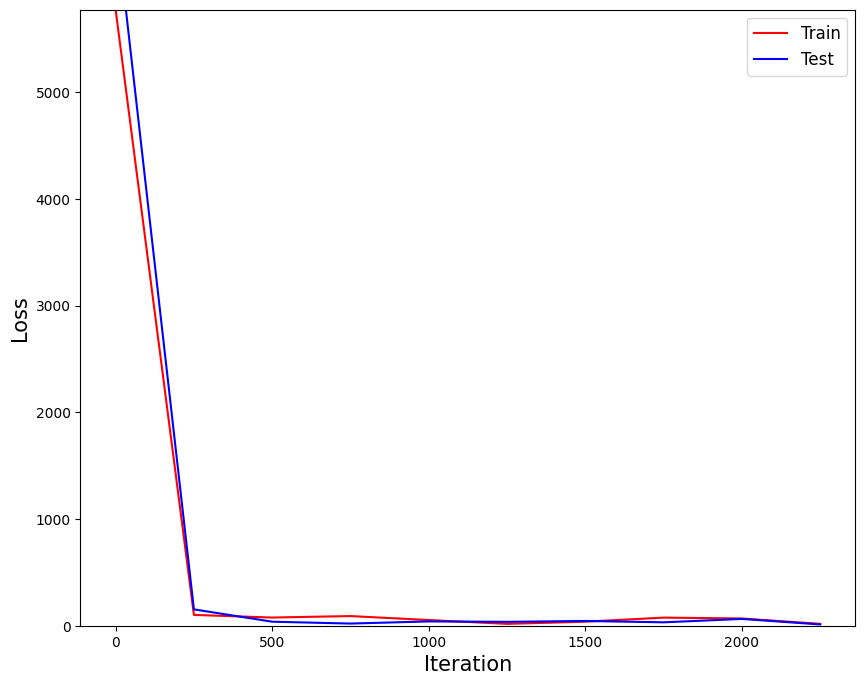

In [21]:
plt.figure(figsize = (10,8))
plt.plot(np.arange(len(loss_record_train))*n_prt, loss_record_train, 'r', label = 'Train')
plt.plot(np.arange(len(loss_record_test))*n_prt, loss_record_test, 'b', label = 'Test')
plt.xlabel('Iteration', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend(fontsize = 12)
plt.ylim([0, np.max(loss_record_train)])
plt.show()

<br>

## 5.2. Testing or Evaluating

In [22]:
# Evaluation
# Get a random batch of test data

test_batch_indices = np.random.choice(test_x.shape[0], size=n_batch, replace=False)
test_batch_x = test_x[test_batch_indices]
test_batch_y = test_y[test_batch_indices]

test_batch_x = test_batch_x.reshape((n_batch, input_h, input_w, input_ch))  # Reshape the batch if needed
# Convert labels to one-hot encoding if necessary
test_batch_y = tf.keras.utils.to_categorical(test_batch_y, num_classes=10)  # Adjust num_classes if needed

my_pred = sess.run(pred, feed_dict={x: test_batch_x.reshape(-1, 28, 28, 1)})
my_pred = np.argmax(my_pred, axis=1)

labels = np.argmax(test_batch_y, axis=1)

accr = np.mean(np.equal(my_pred, labels))
print("Accuracy : {}".format(accr*100))
# Get a random batch of test data
n_batch = 1
test_batch_indices = np.random.choice(test_x.shape[0], size=n_batch, replace=False)
test_batch_x = test_x[test_batch_indices]
test_batch_y = test_y[test_batch_indices]

test_batch_x = test_batch_x.reshape((n_batch, input_h, input_w, input_ch))  # Reshape the batch if needed
# Convert labels to one-hot encoding if necessary
test_batch_y = tf.keras.utils.to_categorical(test_batch_y, num_classes=10)  # Adjust num_classes if needed

logits = sess.run(tf.nn.softmax(pred), feed_dict={x: test_batch_x.reshape(-1, 28, 28, 1)})
predict = np.argmax(logits)


Accuracy : 96.0


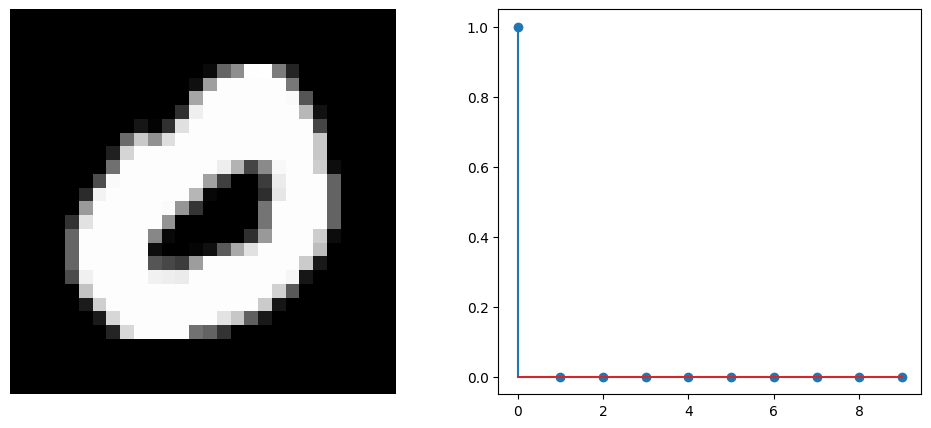

In [23]:
plt.figure(figsize = (12, 5))
plt.subplot(1,2,1)
plt.imshow(test_batch_x.reshape(28, 28), 'gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.stem(logits.ravel())
plt.show()

In [24]:
np.set_printoptions(precision = 2, suppress = True)
print('Prediction : {}'.format(predict))
print('Probability : {}'.format(logits.ravel()))

Prediction : 0
Probability : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# 실습(Debugging)

Iter : 0
Train Loss : 6932.88427734375
Cost : 7190.16064453125
Iter : 250
Train Loss : 114.72479248046875
Cost : 196.6809539794922
Iter : 500
Train Loss : 129.96038818359375
Cost : 106.9178237915039
Iter : 750
Train Loss : 32.38685989379883
Cost : 165.53660583496094
Iter : 1000
Train Loss : 129.3212890625
Cost : 107.36345672607422
Iter : 1250
Train Loss : 16.500961303710938
Cost : 16.580717086791992
Iter : 1500
Train Loss : 13.731178283691406
Cost : 38.7100715637207
Iter : 1750
Train Loss : 50.273048400878906
Cost : 15.800580978393555
Iter : 2000
Train Loss : 90.87035369873047
Cost : 11.07745361328125
Iter : 2250
Train Loss : 37.68413162231445
Cost : 20.06484603881836


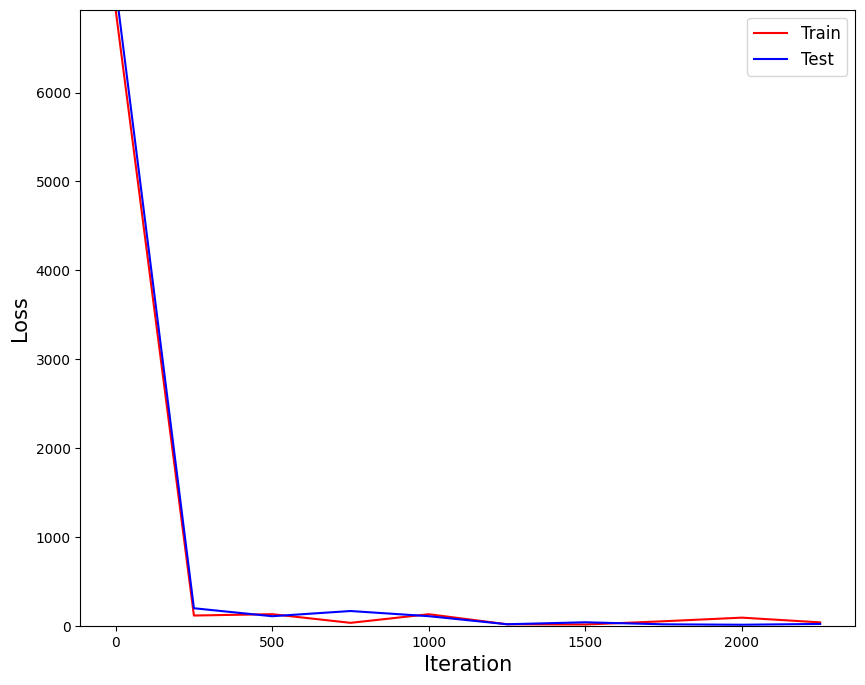

In [25]:
# Optimization

n_batch = 50
n_iter = 2500
n_prt = 250

sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())

loss_record_train = []
loss_record_test = []
for epoch in range(n_iter):
    idx = np.random.choice(train_x.shape[0], size=n_batch, replace=False)
    train_batch_x = train_x[idx]
    train_batch_y = train_y[idx]
    
    train_batch_y = to_categorical(train_batch_y, num_classes=10)
    
    sess.run(optm, feed_dict={x:train_batch_x, y:train_batch_y})

    if epoch % n_prt == 0:
        test_idx = np.random.choice(test_x.shape[0], size=n_batch, replace=False)
        test_batch_x = test_x[test_idx]
        test_batch_y = test_y[test_idx]
        test_batch_x = test_batch_x.reshape((n_batch, input_h, input_w, input_ch))
        
        test_batch_y = to_categorical(test_batch_y, num_classes=10)
        
        c1 = sess.run(loss, feed_dict={x:train_batch_x, y:train_batch_y})
        c2 = sess.run(loss, feed_dict={x:test_batch_x, y:test_batch_y})
        
        # Accuracy 계산
        correct_pred_train = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
        accuracy_train = tf.reduce_mean(tf.cast(correct_pred_train, tf.float32))
        train_acc = sess.run(accuracy_train, feed_dict={x:train_batch_x, y:train_batch_y})

        correct_pred_test = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
        accuracy_test = tf.reduce_mean(tf.cast(correct_pred_test, tf.float32))
        test_acc = sess.run(accuracy_test, feed_dict={x:test_batch_x, y:test_batch_y})

        loss_record_train.append(c1)
        loss_record_test.append(c2)
        print("Iter : {}".format(epoch))
        print("Train Loss : {}".format(c1))
        print("Cost : {}".format(c2))

plt.figure(figsize = (10,8))
plt.plot(np.arange(len(loss_record_train))*n_prt, loss_record_train, 'r', label = 'Train')
plt.plot(np.arange(len(loss_record_test))*n_prt, loss_record_test, 'b', label = 'Test')
plt.xlabel('Iteration', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend(fontsize = 12)
plt.ylim([0, np.max(loss_record_train)])
plt.show()

In [26]:
print("Train_Accuracy : {:.2f}%".format(train_acc * 100))
print("Test_Accuracy : {:.2f}%".format(test_acc * 100))

Train_Accuracy : 96.00%
Test_Accuracy : 92.00%
